In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
file_path = "netflix.csv" 
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429


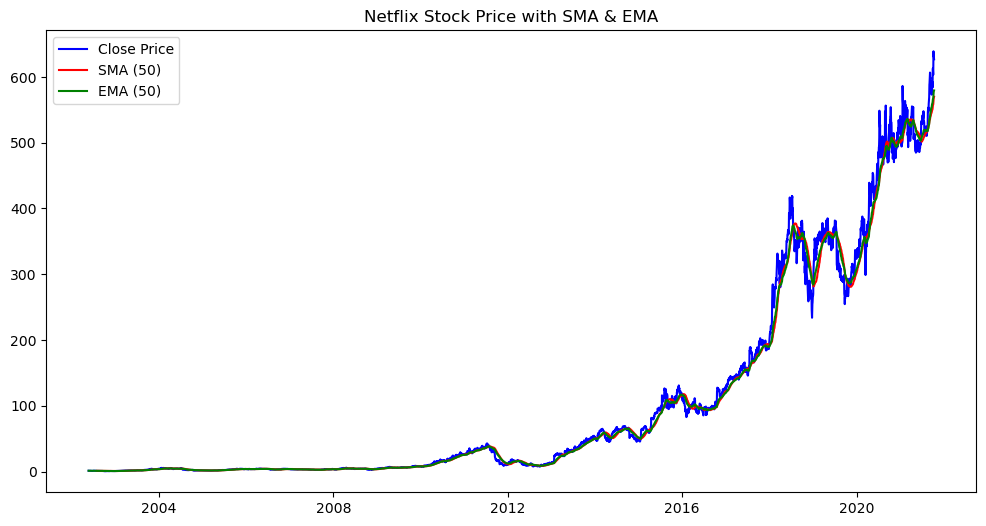

In [3]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()  # Simple Moving Average (50 days)
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Exponential Moving Average
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close Price", color='blue')
plt.plot(df['SMA_50'], label="SMA (50)", color='red')
plt.plot(df['EMA_50'], label="EMA (50)", color='green')
plt.legend()
plt.title("Netflix Stock Price with SMA & EMA")
plt.show()


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Close']])
def create_dataset(data, time_step=50):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)
time_step = 50
X, Y = create_dataset(df_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [5]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
121/121 [==============================] - 7s 41ms/step - loss: 3.0250e-04
Epoch 2/20
121/121 [==============================] - 5s 40ms/step - loss: 3.4317e-05
Epoch 3/20
121/121 [==============================] - 5s 40ms/step - loss: 3.0895e-05
Epoch 4/20
121/121 [==============================] - 5s 39ms/step - loss: 2.8860e-05
Epoch 5/20
121/121 [==============================] - 5s 40ms/step - loss: 2.9766e-05
Epoch 6/20
121/121 [==============================] - 5s 39ms/step - loss: 3.0486e-05
Epoch 7/20
121/121 [==============================] - 5s 40ms/step - loss: 2.4356e-05
Epoch 8/20
121/121 [==============================] - 5s 39ms/step - loss: 2.3801e-05
Epoch 9/20
121/121 [==============================] - 5s 37ms/step - loss: 2.4271e-05
Epoch 10/20
121/121 [==============================] - 5s 40ms/step - loss: 2.1748e-05
Epoch 11/20
121/121 [==============================] - 5s 40ms/step - loss: 2.2550e-05
Epoch 12/20
121/121 [==============================]

In [6]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
rmse_sma = np.sqrt(mean_squared_error(df['Close'][50:], df['SMA_50'][50:]))
rmse_ema = np.sqrt(mean_squared_error(df['Close'][50:], df['EMA_50'][50:]))
rmse_lstm = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f"RMSE - SMA: {rmse_sma:.2f}")
print(f"RMSE - EMA: {rmse_ema:.2f}")
print(f"RMSE - LSTM: {rmse_lstm:.2f}")


31/31 [==============================] - 0s 14ms/step
RMSE - SMA: 15.18
RMSE - EMA: 13.37
RMSE - LSTM: 16.39


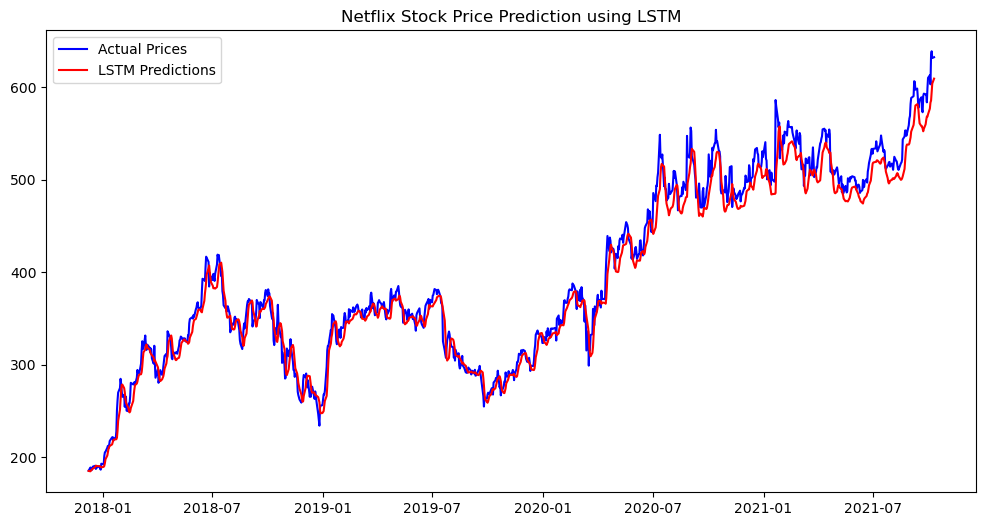

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(Y_test):], Y_test, label="Actual Prices", color='blue')
plt.plot(df.index[-len(Y_test):], test_predict, label="LSTM Predictions", color='red')
plt.legend()
plt.title("Netflix Stock Price Prediction using LSTM")
plt.show()
